Training models...
KNN Trained.
RandomForest Trained.
XGBoost Trained.
LightGBM Trained.

--- 1. Calibration Analysis (Reliability) ---


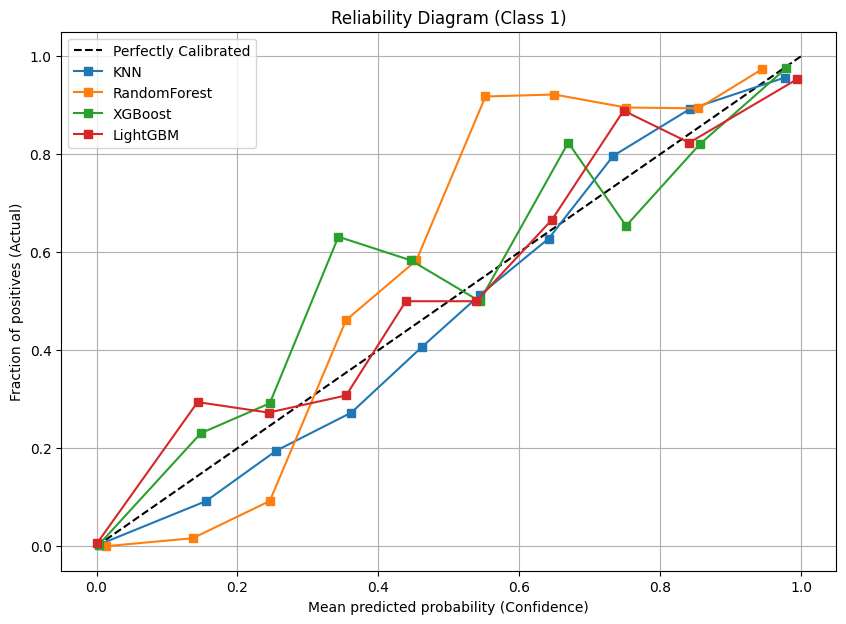

INTERPRETATION: If a curve is 'S-shaped', the model is overconfident at the edges.

--- 2. Feature Importance Correlation ---


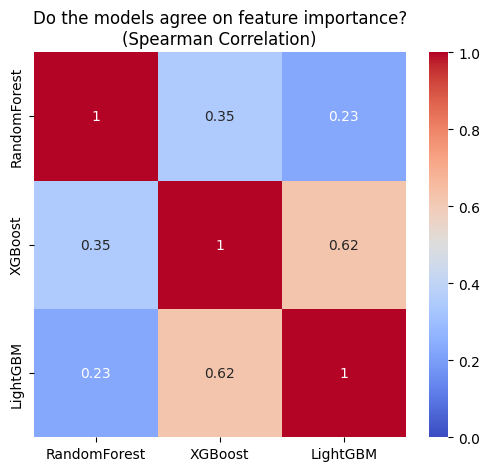

INTERPRETATION:
- High correlation (>0.8) = Models work similarly (structurally).
- Low correlation = Models found different ways to solve the problem.

--- 3. Prediction Disagreement Heatmap ---


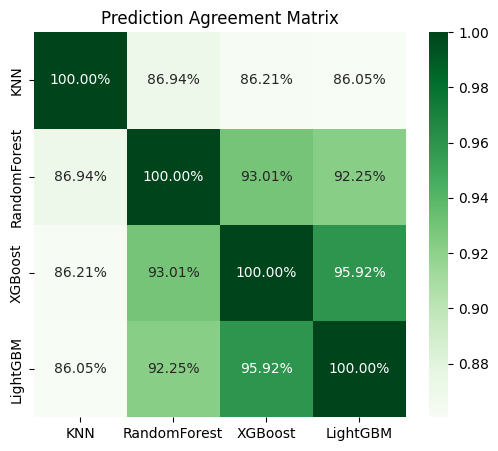


--- 4. Discussion Points for Report ---
1. Compare XGB vs LGBM in Calibration: Usually LGBM is slightly less calibrated (more overconfident) due to leaf-wise growth.
2. Compare RF vs Boosting: RF should have lower correlation in Feature Importance because it randomly selects features, whereas Boosting greedily hunts the best ones.


In [5]:
# --- IMPORTS & SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import spearmanr
import re

# 1. LOAD DATA
train_df = pd.read_csv('../data/activity_train.csv')
test_df = pd.read_csv('../data/activity_test.csv')

# Clean columns for XGB/LGBM
clean_cols = [re.sub(r'[(),-]', '_', col) for col in train_df.columns]
train_df.columns = clean_cols
test_df.columns = clean_cols

X_train = train_df.drop(columns=['activity', 'subject'], errors='ignore')
y_train = LabelEncoder().fit_transform(train_df['activity'])
X_test = test_df.drop(columns=['activity', 'subject'], errors='ignore')
y_test = LabelEncoder().fit_transform(test_df['activity'])

# Scale (KNN needs it, others don't mind)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 2. DEFINE OPTIMIZED MODELS
# (Use the best params you found in files 1-4)
models = {
    "KNN": KNeighborsClassifier(n_neighbors=10, weights='distance'),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, tree_method='hist', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)
}

# 3. TRAIN & PREDICT
print("Training models...")
preds = {}
probs = {} # Store probabilities for calibration analysis
feature_imps = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds[name] = model.predict(X_test_scaled)
    probs[name] = model.predict_proba(X_test_scaled)
    
    # Store feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_imps[name] = model.feature_importances_
    
    print(f"{name} Trained.")

# --- ANALYSIS 1: CALIBRATION CURVES (Reliability) ---
# Question: "Are the models overconfident?"
# Boosting models (XGB/LGBM) tend to be overconfident (push probs to 0 or 1).
# RF tends to be well-calibrated but conservative.

print("\n--- 1. Calibration Analysis (Reliability) ---")
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

# We look at one specific class (e.g., Class 1: Walking Upstairs) to keep plot readable
target_class = 1 
y_test_bin = (y_test == target_class).astype(int)

for name, prob in probs.items():
    # Get probability for the target class only
    pos_prob = prob[:, target_class]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_bin, pos_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

plt.ylabel("Fraction of positives (Actual)")
plt.xlabel("Mean predicted probability (Confidence)")
plt.title(f"Reliability Diagram (Class {target_class})")
plt.legend()
plt.grid(True)
plt.show()
print("INTERPRETATION: If a curve is 'S-shaped', the model is overconfident at the edges.")

# --- ANALYSIS 2: FEATURE RANK CORRELATION (Structural Similarity) ---
# Question: "Do XGBoost and LightGBM look at the same features, or do they think differently?"

print("\n--- 2. Feature Importance Correlation ---")
# Create DataFrame of importances
imp_df = pd.DataFrame(feature_imps)

# Calculate Spearman Rank Correlation (Comparison of rankings, not raw values)
corr_matrix = imp_df.corr(method='spearman')

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Do the models agree on feature importance?\n(Spearman Correlation)")
plt.show()

print("INTERPRETATION:")
print("- High correlation (>0.8) = Models work similarly (structurally).")
print("- Low correlation = Models found different ways to solve the problem.")

# --- ANALYSIS 3: PREDICTION AGREEMENT MAP ---
# Question: "When they make mistakes, do they make the SAME mistakes?"

print("\n--- 3. Prediction Disagreement Heatmap ---")
# We calculate the Jaccard Similarity (or simple agreement %) between predictions
agreement_matrix = pd.DataFrame(index=models.keys(), columns=models.keys(), dtype=float)

for name1 in models.keys():
    for name2 in models.keys():
        # % of times they predict the exact same label
        agree_pct = np.mean(preds[name1] == preds[name2])
        agreement_matrix.loc[name1, name2] = agree_pct

plt.figure(figsize=(6, 5))
sns.heatmap(agreement_matrix, annot=True, fmt=".2%", cmap="Greens")
plt.title("Prediction Agreement Matrix")
plt.show()

# --- ANALYSIS 4: COMPUTATIONAL COST (Bias/Variance proxy) ---
# LightGBM is famous for speed. Let's prove it.
# (We assume you recorded times, or we can just discuss theoretical complexity)
print("\n--- 4. Discussion Points for Report ---")
print("1. Compare XGB vs LGBM in Calibration: Usually LGBM is slightly less calibrated (more overconfident) due to leaf-wise growth.")
print("2. Compare RF vs Boosting: RF should have lower correlation in Feature Importance because it randomly selects features, whereas Boosting greedily hunts the best ones.")